In [1]:
# load library

In [1]:
import numpy as np
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# load sklearn Library

In [2]:
from sklearn.metrics import mean_absolute_error,r2_score, mean_squared_log_error,mean_squared_error, make_scorer

In [5]:
# load XGboost Library

In [3]:
from xgboost.sklearn import XGBRegressor
from xgboost import plot_importance

In [4]:
data = pd.read_csv("london_merged.csv")
data

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [8]:
# Data Processing

In [5]:
X = data.drop(['timestamp','cnt','t2'],axis=1)
y = data['cnt']

In [6]:
def df_split(df,train_percent):
    split_index = int(train_percent * len(df))
    train = df.iloc[:split_index]
    test = df.iloc[split_index:]
    return train,test

In [11]:
# split into train / test data

In [7]:
X_train,X_test = df_split(X,0.7)
y_train,y_test = df_split(y,0.7)

In [ ]:
# Train Model

In [8]:
import time

xgbmodel = XGBRegressor(max_depth=7, learning_rate=0.1, n_estimators=550,objective='reg:squarederror')
t1 = time.time()
xgbmodel.fit(X_train,y_train)
t2 = time.time()
print('Time',t2-t1)

Time 1.272782802581787


In [15]:
# RMSE

In [9]:
preds = xgbmodel.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 1056.991044


In [ ]:
# Plot

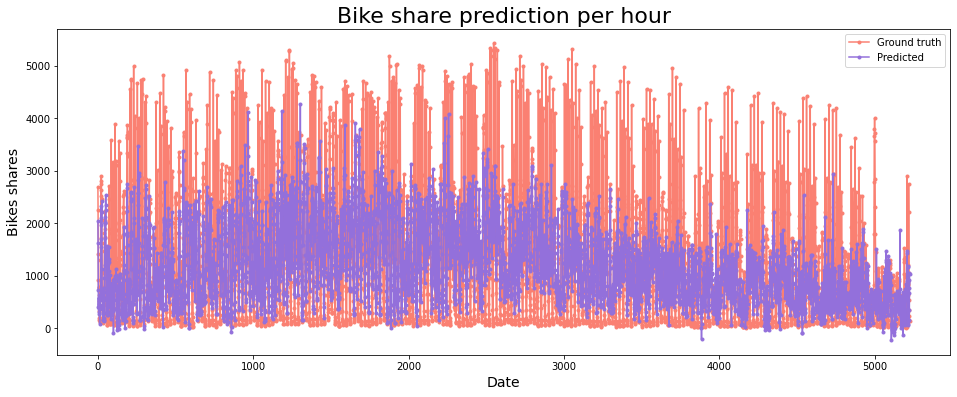

In [17]:
plt.figure(figsize=(16,6))
plt.plot(y_test.values,marker=".",label="actual",color="#fa8072")
plt.plot(preds,marker=".",label="prediction",color="#9370db")

plt.title('Bike share prediction per hour', fontsize=22)
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel(ylabel='Bikes shares', fontsize=14)
plt.legend(['Ground truth', 'Predicted'])

plt.show()

In [ ]:
# 顯示col對模型的重要性

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

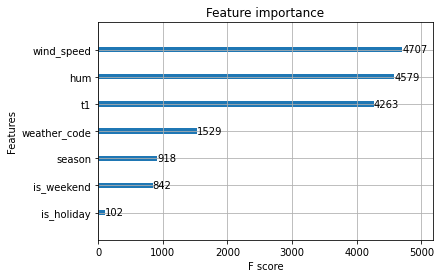

In [18]:
plot_importance(xgbmodel)

In [19]:
# 計算正確率

In [32]:
#def 正確率
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if int(preds[i]) == int(y_test.values[i]):
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

Accuracy: 0.06 % 


In [ ]:
# tuneing

In [34]:
from sklearn.model_selection import GridSearchCV

In [46]:
cv_params = {'learning_rate': [0.09, 0.1, 0.11]}
other_params = {'learning_rate': 0.1, 'n_estimators': 100, 'max_depth': 3, 'min_child_weight': 6, 'seed': 0,
                'subsample': 0.7, 'colsample_bytree': 0.8, 'gamma': 0.1, 'reg_alpha': 3, 'reg_lambda': 1}

model = XGBRegressor(**other_params)
optimized_GBM = GridSearchCV(estimator=model, param_grid=cv_params, scoring='neg_root_mean_squared_error', cv=5, verbose=1,n_jobs=4)
optimized_GBM.fit(X_train, y_train)
evalute_result = optimized_GBM.cv_results_
print('每輪迭代執行結果:{0}'.format(evalute_result))
print('引數的最佳取值：{0}'.format(optimized_GBM.best_params_))
print('最佳模型得分:{0}'.format(optimized_GBM.best_score_))

Fitting 5 folds for each of 3 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


每輪迭代執行結果:{'mean_fit_time': array([0.21841526, 0.22559638, 0.19248533]), 'std_fit_time': array([0.00488631, 0.00212932, 0.02364342]), 'mean_score_time': array([0.00618429, 0.00458779, 0.00259304]), 'std_score_time': array([0.00270532, 0.00135269, 0.00048871]), 'param_learning_rate': masked_array(data=[0.09, 0.1, 0.11],
             mask=[False, False, False],
       fill_value='?',
            dtype=object), 'params': [{'learning_rate': 0.09}, {'learning_rate': 0.1}, {'learning_rate': 0.11}], 'split0_test_score': array([-762.71664574, -761.51863357, -763.63084992]), 'split1_test_score': array([-966.98583169, -965.17111664, -965.55681449]), 'split2_test_score': array([-958.30417517, -957.88929756, -956.0180306 ]), 'split3_test_score': array([-778.91579674, -776.54205541, -777.89951437]), 'split4_test_score': array([-857.78790152, -856.01986595, -856.85210917]), 'mean_test_score': array([-864.94207017, -863.42819383, -863.99146371]), 'std_test_score': array([86.05945754, 86.32979243, 85.2

[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed:    0.8s finished


In [47]:
# Fine Tune Model

In [9]:
import time
xgbmodel_fine = XGBRegressor(max_depth=3, subsample = 0.7, colsample_bytree = 0.8,learning_rate=0.1, n_estimators=100,min_child_weight = 6,objective='reg:squarederror',reg_alpha = 3, reg_lambda = 1)
t1 = time.time()
xgbmodel_fine.fit(X_train,y_train)
t2 = time.time()
print('Train time: ',t2-t1)

t1 = time.time()
preds = xgbmodel_fine.predict(X_test)
t2 = time.time()
print('Train time: ',t2-t1)

rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))
r2 =  r2_score(y_test, preds)
print('R2: ',r2)

#def 正確率
cnt1 = 0
cnt2 = 0
for i in range(len(y_test)):
    if int(preds[i]) == int(y_test.values[i]):
        cnt1 += 1
    else:
        cnt2 += 1

print("Accuracy: %.2f %% " % (100 * cnt1 / (cnt1 + cnt2)))

Train time:  0.11965441703796387
Train time:  0.0024995803833007812
RMSE: 979.475704
R2:  0.294837845755037
Accuracy: 0.06 % 


In [ ]:
# PLOT

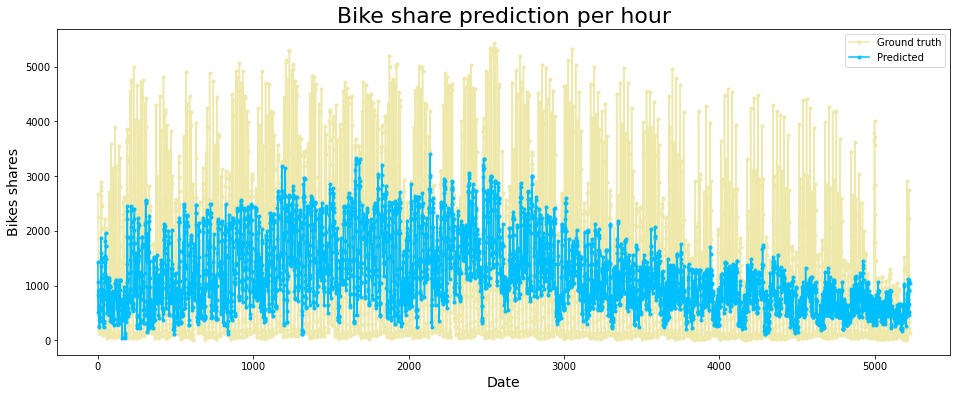

In [10]:
plt.figure(figsize=(16,6))
plt.plot(y_test.values,marker=".",label="actual",color="#eee8aa")
plt.plot(preds,marker=".",label="prediction",color="#00bfff")

plt.title('Bike share prediction per hour', fontsize=22)
plt.xlabel(xlabel='Date', fontsize=14)
plt.ylabel(ylabel='Bikes shares', fontsize=14)
plt.legend(['Ground truth', 'Predicted'])

plt.show()

In [ ]:
# Importance

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

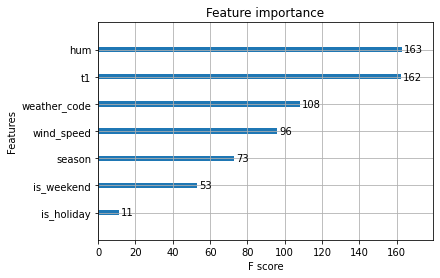

In [11]:
plot_importance(xgbmodel_fine)